In [640]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV,KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [506]:
my_data = pd.read_csv('loans_full_schema.csv')
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

In [507]:
pd.set_option("display.max_columns", None)

In [508]:
my_data.describe()

,emp_length,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,9183.000000,1.000000e+04,9976.000000,1.495000e+03,1495.000000,10000.00000,4342.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,2285.000000,10000.0000,10000.000000,10000.000000,10000.000000,8729.000000,10000.000000,9682.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,22.679600,11.40440,1.836062e+05,51049.063100,0.013800,0.167100,46.112473,0.0001,184.334000,2.663600,4.376100,7.340703,11.379600,0.0,0.0001,3.595300,27357.410300,13.030000,8.095000,5.230500,1.383100,94.648990,0.043300,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.703734,6.473429e+04,15.004851,7.016838e+04,8.054781,0.68366,21.634939,7.79551,2.38013,11.885439,5.86828,1.876327e+05,53636.731172,0.126535,0.687768,21.748021,0.0100,2206.389859,2.935387,3.158583,5.981590,5.859705,0.0,0.0100,2.434689,26570.164081,7.874713,4.906606,3.327623,1.717274,9.155059,0.593852,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,2.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,14.300000,0.000000,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.500000e+04,11.057500,8.683350e+04,14.160000,0.00000,19.000000,1997.00000,0.00000,14.000000,7.00000,5.159375e+04,19185.500000,0.000000,0.000000,29.000000,0.0000,0.000000,1.000000,2.000000,2.000000,7.000000,0.0,0.0000,2.000000,10000.000000,7.000000,5.000000,3.000000,0.000000,92.600000,0.000000,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,6.000000,6.500000e+04,17.570000,1.130000e+05,19.720000,0.00000,34.000000,2003.00000,1.00000,21.000000,10.00000,1.146670e+05,36927.000000,0.000000,0.000000,47.000000,0.0000,0.000000,2.000000,4.000000,6.000000,10.000000,0.0,0.0000,3.000000,19500.000000,11.000000,7.000000,5.000000,1.000000,100.000000,0.000000,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,9.500000e+04,25.002500,1.515455e+05,25.500000,0.00000,53.000000,2006.00000,3.00000,29.000000,14.00000,2.675500e+05,65421.000000,0.000000,0.000000,63.000000,0.0000,0.000000,3.000000,6.000000,11.000000,14.000000,0.0,0.0000,5.000000,36100.000000,17.000000,10.000000,7.000000,2.000000,100.000000,0.000000,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,87.000000,51.00000,3.386034e+06,942456.000000,3.000000,52.

### Drop columns because of data leakage

In [509]:
my_data = my_data.drop(['issue_month','loan_status','initial_listing_status','disbursement_method','installment','balance','paid_total','paid_principal','paid_interest','paid_late_fees'],1)

### Replace categorical value with numerical value

In [510]:
my_data.groupby(['homeownership']).size()
my_data['homeownership']=my_data['homeownership'].replace(['MORTGAGE','OWN','RENT'],[1,2,0])
my_data.groupby(['verified_income']).size()
my_data.groupby(['verification_income_joint']).size()
my_data['verified_income']=my_data['verified_income'].replace(['Not Verified','Source Verified','Verified'],[0,2,1])
my_data['verification_income_joint']=my_data['verification_income_joint'].replace(['Not Verified','Source Verified','Verified'],[0,2,1])
my_data.groupby(['sub_grade']).size()
l = list(range(1,36))
p =sorted(l,reverse = True)
q = list(range(1,14))
my_data['sub_grade']= my_data['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5','D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5'],p)
my_data.groupby(['loan_purpose']).size()
my_data['loan_purpose']= my_data['loan_purpose'].replace(['car','credit_card','debt_consolidation','home_improvement','house','major_purchase','medical','moving','other','renewalbe_energy','small_business','vacation','renewable_energy'],q)

### Drop features dulicated or too hard to analyze 

In [511]:
my_data = my_data.drop(['emp_title','state','grade'],1)

### Review features with large amount of duplicate values

In [512]:
my_data['num_accounts_30d_past_due'].describe()

count    10000.0000
mean         0.0001
std          0.0100
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: num_accounts_30d_past_due, dtype: float64

In [513]:
my_data['num_accounts_120d_past_due'].describe()


count    9682.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: num_accounts_120d_past_due, dtype: float64

In [514]:
my_data['current_accounts_delinq'].describe()

count    10000.0000
mean         0.0001
std          0.0100
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max          1.0000
Name: current_accounts_delinq, dtype: float64

In [515]:
my_data = my_data.drop(['num_accounts_120d_past_due','num_accounts_30d_past_due','current_accounts_delinq'],1)

### Combine Joint Application and Individual Application

In [516]:
index = my_data.index
condition = my_data['application_type']=='joint'
indice = index[condition]
joint_row = indice.tolist()
my_data.loc[joint_row,['annual_income']] = my_data[my_data['application_type']=='joint']['annual_income_joint']
my_data.loc[joint_row,['debt_to_income']] = my_data[my_data['application_type']=='joint']['debt_to_income_joint']
indx = my_data.columns.get_loc('verified_income')
for i in joint_row:
    single = my_data['verification_income_joint'][i]
    joint = my_data['verified_income'][i]
    if joint < single:
        my_data.iloc[i,indx] = my_data['verification_income_joint'][i]

my_data = my_data.drop(['annual_income_joint','verification_income_joint','debt_to_income_joint','application_type'],1)     

### Modify "year" with meaningful "time length"

In [517]:
my_data['earliest_credit_line'] = my_data['earliest_credit_line'].apply(lambda x: 2021 -x )

In [518]:
my_data = pd.DataFrame(my_data)

## Handle Missing Values

In [519]:
## Missing Values
null_values = my_data.isnull().sum().to_frame().reset_index()
null_values.columns = ['Variables', 'Null_counts']
null_values['Null_pct'] = null_values['Null_counts'] / my_data.shape[0]
null_values.sort_values(by='Null_pct', ascending=False)

,Variables,Null_counts,Null_pct
15,months_since_90d_late,7715,0.7715
6,months_since_last_delinq,5658,0.5658
19,months_since_last_credit_inquiry,1271,0.1271
0,emp_length,817,0.0817
26,num_mort_accounts,0,0.0000
21,num_active_debit_accounts,0,0.0000
22,total_debit_limit,0,0.0000
23,num_total_cc_accounts,0,0.0000
24,num_open_cc_accounts,0,0.0000
25,num_cc_carrying_balance,0,0.0000


### Replace NA employment length with 0 

In [520]:
my_data.loc[my_data['emp_length'].isnull(), 'emp_length'] = 0

### Look Closer into "months since", drop highly correlated, fill NA 

In [521]:
my_data[['months_since_90d_late','months_since_last_delinq','months_since_last_credit_inquiry']].corr()

,months_since_90d_late,months_since_last_delinq,months_since_last_credit_inquiry
months_since_90d_late,1.000000,0.711232,0.012338
months_since_last_delinq,0.711232,1.000000,-0.027598
months_since_last_credit_inquiry,0.012338,-0.027598,1.000000


In [522]:
my_data = my_data.drop('months_since_90d_late',1)

In [523]:
my_data.loc[my_data['months_since_last_delinq'].isnull(), 'months_since_last_delinq'] = max(my_data['months_since_last_delinq'])
my_data.loc[my_data['months_since_last_credit_inquiry'].isnull(), 'months_since_last_credit_inquiry'] = max(my_data['months_since_last_credit_inquiry'])

## Review cleaned data, double check for highly correlated columns 

<AxesSubplot:>

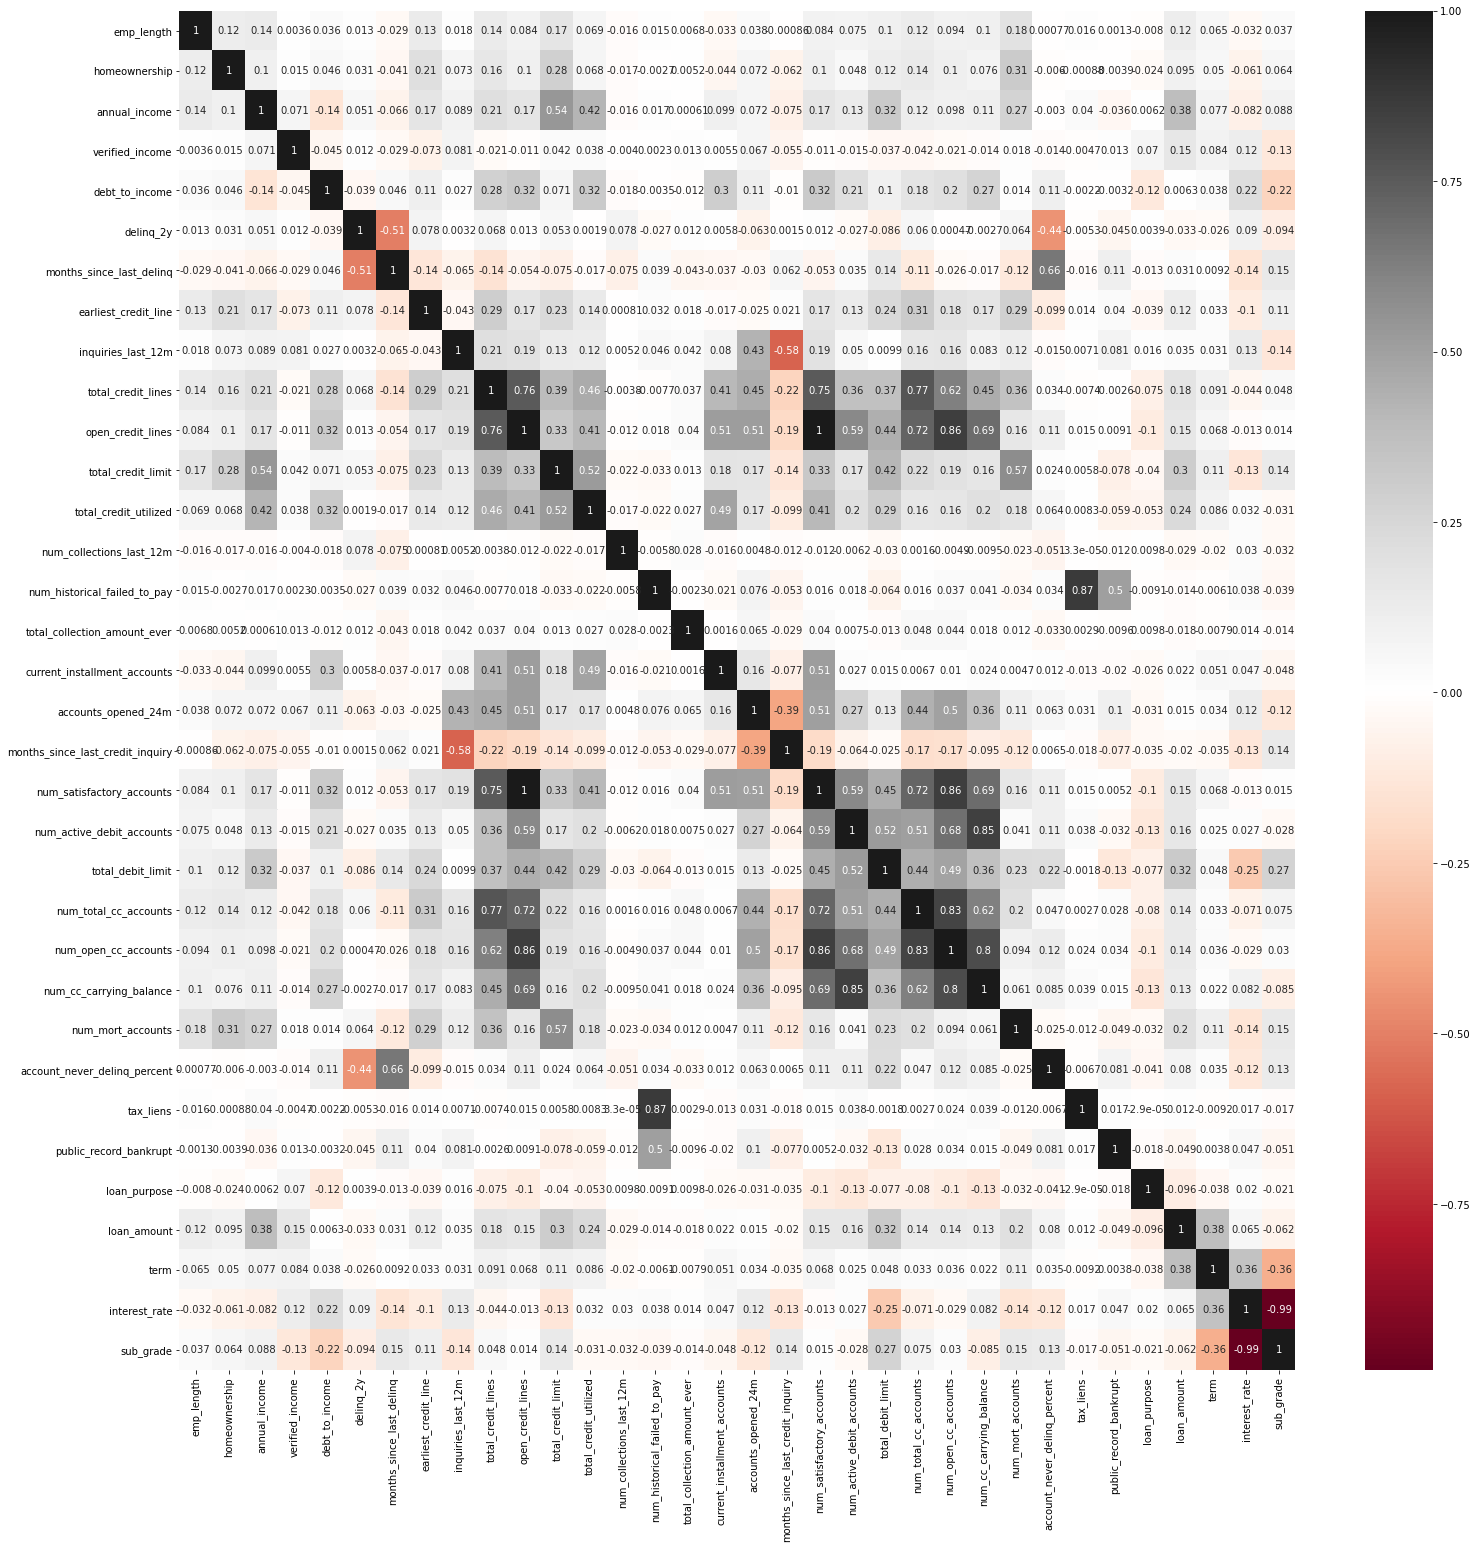

In [524]:
cormatrix = my_data.corr()
plt.figure(figsize=(25,25))
sns.heatmap(cormatrix, annot=True, cmap='RdGy')

In [525]:
my_data = my_data.drop(['sub_grade','open_credit_lines'],1)

### Data Scaling 

In [526]:
y = my_data['interest_rate']
X = my_data.drop(['interest_rate'],1)

In [527]:
new_data = X
cat_feature = new_data[['homeownership','loan_purpose', 'verified_income']]
num_feature = new_data.drop(['homeownership','loan_purpose', 'verified_income'],1)

In [528]:
scaler = MinMaxScaler()
scaler.fit(num_feature)
num_feature = pd.DataFrame(scaler.transform(num_feature),columns=[num_feature.columns])

In [529]:
my_processed_X = num_feature.join(cat_feature)
y = pd.DataFrame(y, columns = ['interest_rate'])

## Data Modeling 

### Lasso

In [530]:
inner_cv = KFold(n_splits = 4, shuffle = True)
outer_cv = KFold(n_splits = 5, shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(my_processed_X, y, test_size=0.3, random_state=11)

In [533]:
lasso = Lasso(random_state=42) 
            
lasso_params = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5],
                'normalize': [True, False],
                'tol':[0.0001, 0.001, 0.01, 1]}

gs_lasso = GridSearchCV(lasso, param_grid = lasso_params, scoring = 'neg_root_mean_squared_error', cv=inner_cv) # cross-validation scores
gs_lasso = gs_lasso.fit(X_train, y_train)
print("Non-nested CV RMSE score: ", gs_lasso.best_score_)
print("Optimal Parameter: ", gs_lasso.best_params_)    
print("Optimal Estimator: ", gs_lasso.best_estimator_) 



Non-nested CV RMSE score:  -4.454695919702447
Optimal Parameter:  {'alpha': 0.1, 'normalize': False, 'tol': 1}
Optimal Estimator:  Lasso(alpha=0.1, normalize=False, random_state=42, tol=1)


#### Generalization Performance Using Cross-validation

In [536]:
lasso_best = Lasso(random_state=42, alpha=0.2, normalize=False, tol=0.001) 
best_lasso_scores = cross_val_score(lasso_best, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=outer_cv) # cross-validation scores
print("Lasso Best Model Generalized Performance: %0.2f (+/- %0.2f)" % (-best_lasso_scores.mean(), best_lasso_scores.std() * 2))

Lasso Best Model Generalized Performance: 4.61 (+/- 0.23)


### Decision Tree Regressor 

In [544]:
tree_params = {'max_depth':range(1,10), 
               'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,0.01]}

gs_dt = GridSearchCV(DecisionTreeRegressor(random_state = 42), tree_params, cv=inner_cv, scoring = 'neg_root_mean_squared_error',n_jobs = 5)
gs_dt = gs_dt.fit(X_train, y_train)
print("Non-nested CV RMSE score: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)    
print("Optimal Estimator: ", gs_dt.best_estimator_) 

Non-nested CV RMSE score:  -4.323158333830511
Optimal Parameter:  {'max_depth': 5, 'min_impurity_decrease': 0.001}
Optimal Estimator:  DecisionTreeRegressor(max_depth=5, min_impurity_decrease=0.001, random_state=42)


In [547]:
tree_best = DecisionTreeRegressor(random_state = 42, max_depth=5, min_impurity_decrease=0.001, criterion='mse') 
best_tree_scores = cross_val_score(tree_best, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=outer_cv) # cross-validation scores
print("Decision Tree Best Model Generalized Performance: %0.2f (+/- %0.2f)" % (-best_tree_scores.mean(), best_tree_scores.std() * 2))

Decision Tree Best Model Generalized Performance: 4.31 (+/- 0.18)


### ElasticNet

### Test 

In [574]:
lasso_yhat = lasso_best.fit(X_train, y_train).predict(X_test)
dt_yhat = tree_best.fit(X_train, y_train).predict(X_test)

In [583]:
lasso_best.coef_

array([-0.        , -0.        ,  0.72000789,  0.        , -0.51246722,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.05333359, -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  2.82335907, -0.09536712,  0.03093647,
        0.32330522])

In [652]:
coef = [2,4,15,27,28,29,30]
sig_feature = list()
for i in coef:
    sig_feature.append(X_train.columns[i])
sig_feature
    

[('debt_to_income',),
 ('months_since_last_delinq',),
 ('months_since_last_credit_inquiry',),
 ('term',),
 'homeownership',
 'loan_purpose',
 'verified_income']

### Result Visualization 

In [592]:
x = list(range(1,len(lasso_yhat)+1))

#### Lasso 

(3.0, 33.0)

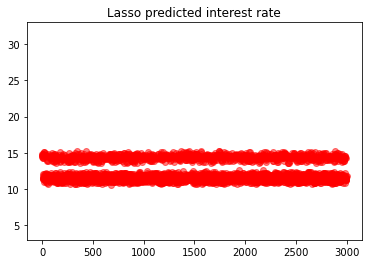

In [627]:
plt.scatter(x, lasso_yhat,color = 'red',alpha = 0.5)
plt.title("Lasso predicted interest rate")
plt.ylim(3, 33)

(3.0, 33.0)

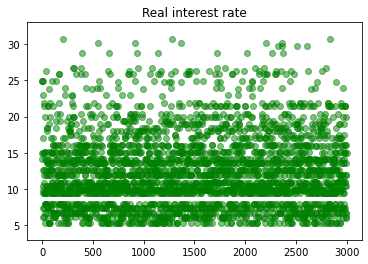

In [626]:
plt.scatter(x,y_test,color = 'green', alpha = 0.5)
plt.title("Real interest rate")
plt.ylim(3, 33)

(-10.0, 20.0)

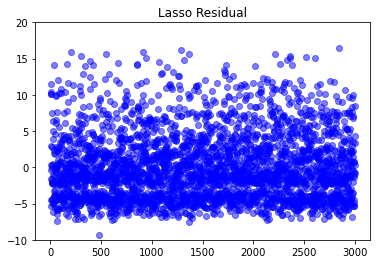

In [632]:
lass_rs = np.array(y_test).T-np.array(lasso_yhat)
plt.scatter(x, lass_rs, color = 'blue', alpha = 0.5)
plt.title("Lasso Residual")
plt.ylim(-10, 20)

#### Decision Tree 

In [595]:
dt_yhat = tree_best.fit(X_train, y_train).predict(X_test)
x = list(range(1,len(dt_yhat)+1))

(3.0, 33.0)

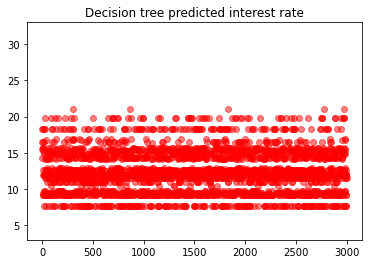

In [631]:
plt.scatter(x, dt_yhat,color = 'red',alpha = 0.5)
plt.title("Decision tree predicted interest rate")
plt.ylim(3, 33)

(3.0, 33.0)

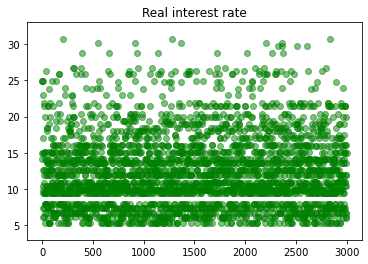

In [630]:
plt.scatter(x,y_test,color = 'green', alpha = 0.5)
plt.title("Real interest rate")
plt.ylim(3, 33)

(-10.0, 20.0)

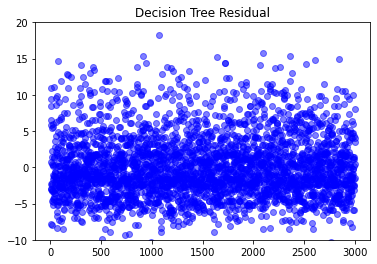

In [633]:
dt_rs = np.array(y_test).T-np.array(dt_yhat)
plt.scatter(x, dt_rs, color = 'blue', alpha = 0.5)
plt.title("Decision Tree Residual")
plt.ylim(-10, 20)

#### ElasticNet 

In [ ]:
## More model should be tested on if more time allowed.  Such as ElastiNet mentioned about, and also randomforest for decision tree.
## Also, more detailed dataset cleaning should be done. I would look into more about company's background information while doing feature selecture.
## For example, I simply put max value for three '#month since' features which should acturally mean that client never pay late or get inquired. Better NA filled value should be considered.
## Regarding the geographical information "state", I simply drop it here. However, I do believe that the location matters. Train different models for different state respectvely may be applicable.